In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
sc.settings.verbosity = 3  

In [2]:
adata=sc.read("adata_all.h5ad")

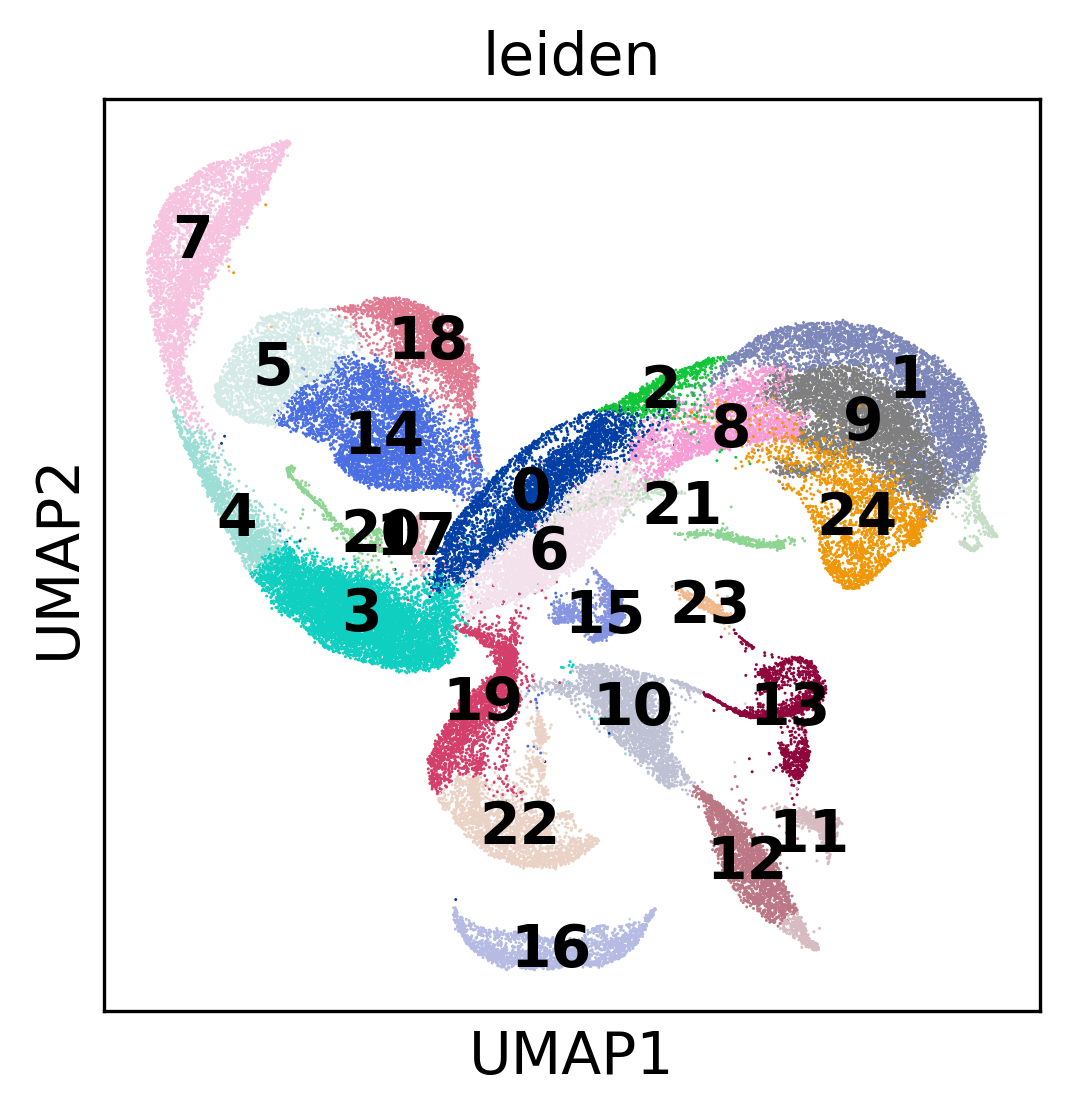

In [3]:
sc.settings.set_figure_params(dpi=150, facecolor='white')
sc.pl.umap(adata,color="leiden",legend_loc="on data")

In [4]:
adata=adata[adata.obs.leiden.isin(["0","6","2","8","9","1","24"]),]

In [5]:
adata.obs["sample"].value_counts()

UMM064      7097
UMM059      5096
UMM061      4454
UMM065      2098
UMM067L      910
UMM069       562
UMM062       320
UMM063        10
BSSR0022       9
UMM066         9
UMM041L        2
Name: sample, dtype: int64

In [6]:
adata=adata[adata.obs["sample"].isin(["UMM059"])]

In [7]:
sc.pp.filter_genes(adata,min_cells=3)

filtered out 6685 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


In [8]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger")

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [9]:
import cupy as cp
import rapids_scanpy_funcs as rap
scaled = cp.array(adata[:,adata.var["highly_variable"]].X.todense(), order="F")
scaled = rap.scale(scaled, max_value=10)

In [10]:
from cuml import PCA
adata.obsm["X_pca"] = (PCA(n_components=50).fit_transform(scaled)).get()

In [150]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=5,method="rapids")
sc.tl.umap(adata,method="rapids")

from scanpy._utils import _choose_graph
adjacency = _choose_graph(adata,None,None)
import cudf
import cugraph
import pandas as pd
offsets = cudf.Series(adjacency.indptr)
indices = cudf.Series(adjacency.indices)
weights = None
g = cugraph.Graph()
g.add_adj_list(offsets, indices, weights)
leiden_parts, _ = cugraph.leiden(g,resolution=0.4)
groups = leiden_parts.to_pandas().sort_values('vertex')[['partition']].to_numpy().ravel()
adata.obs["leiden"]=groups.astype(str)

/home/lfaure/miniconda3/envs/gpu/lib/python3.8/site-packages/cugraph/structure/graph.py:623: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  warnings.warn(


/home/lfaure/miniconda3/envs/gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden' as categorical


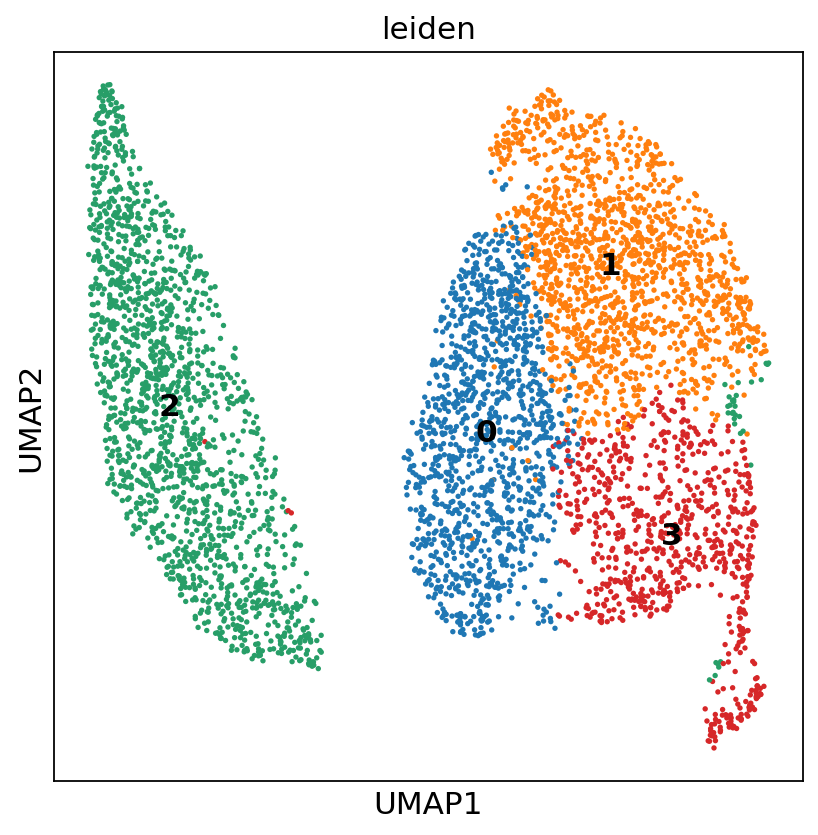

In [151]:
sc.pl.umap(adata,color="leiden",legend_loc="on data")

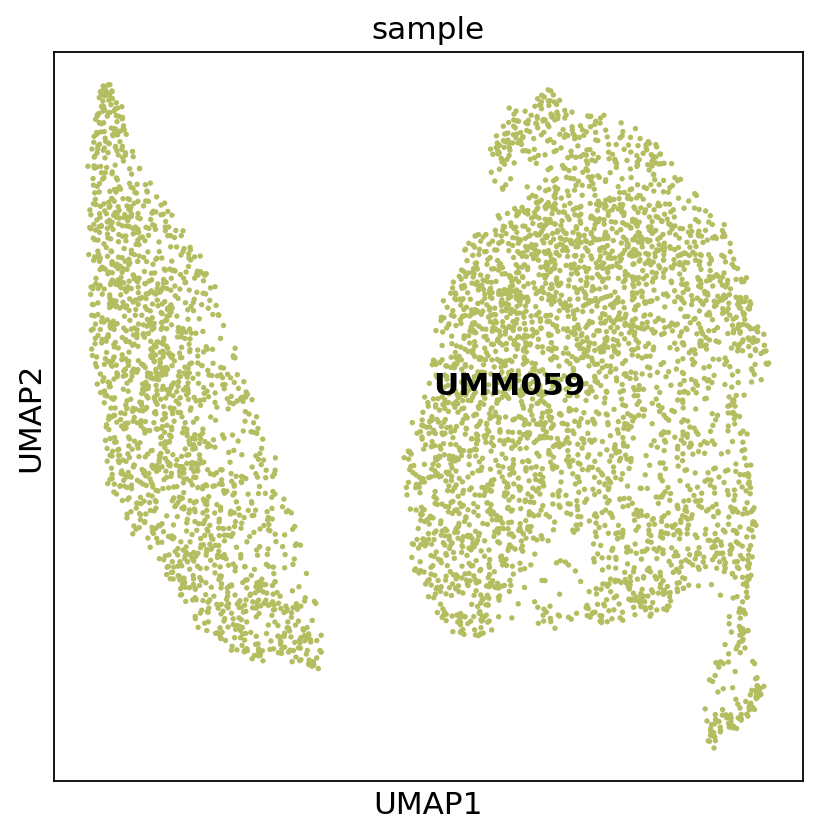

In [152]:
sc.pl.umap(adata,color="sample",legend_loc="on data")

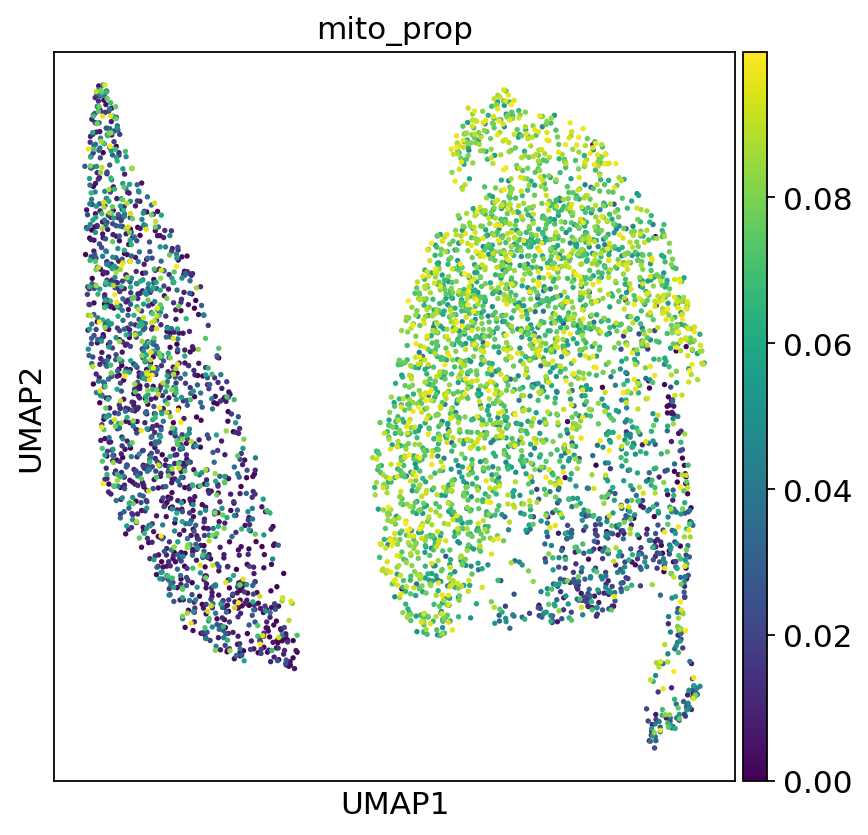

In [153]:
sc.pl.umap(adata,color="mito_prop",legend_loc="on data")

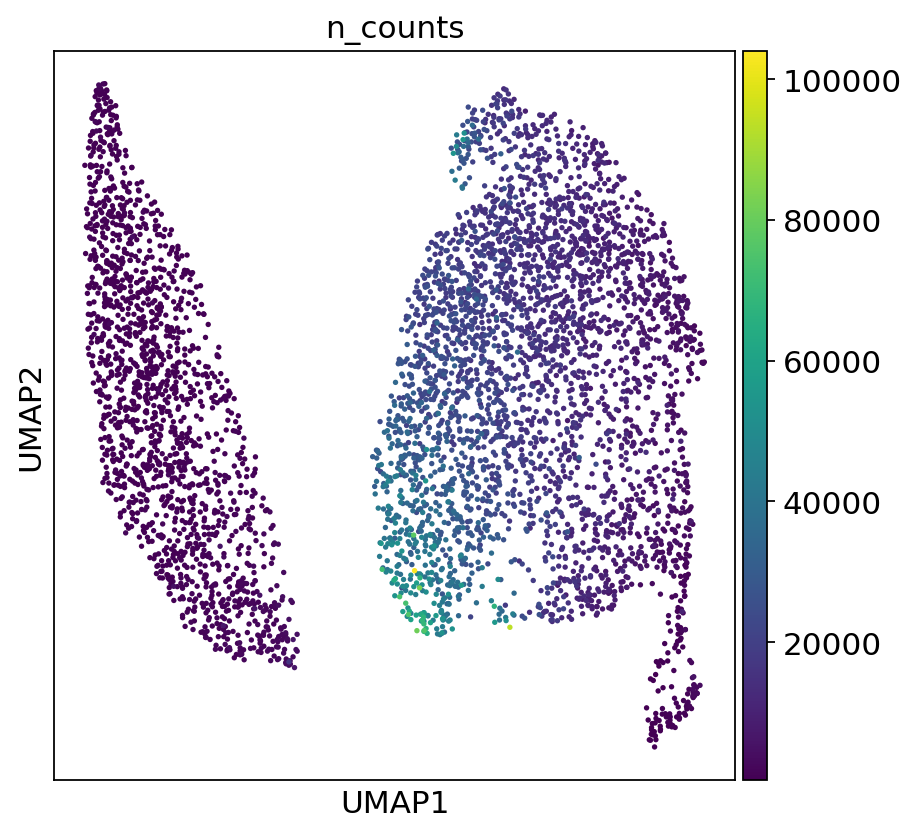

In [154]:
sc.pl.umap(adata,color="n_counts",legend_loc="on data")

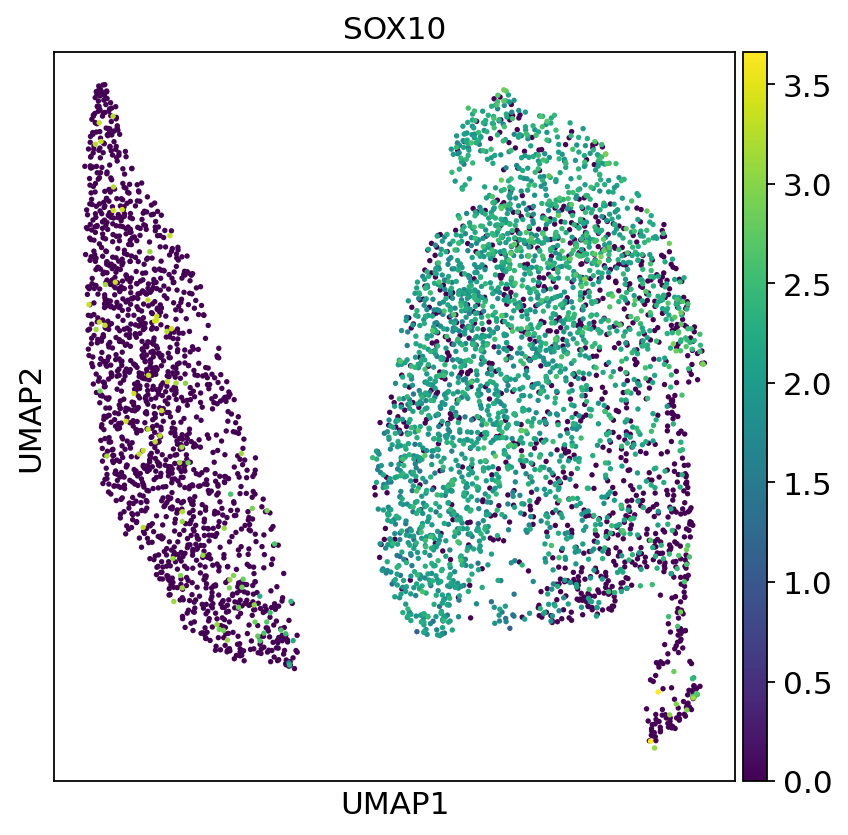

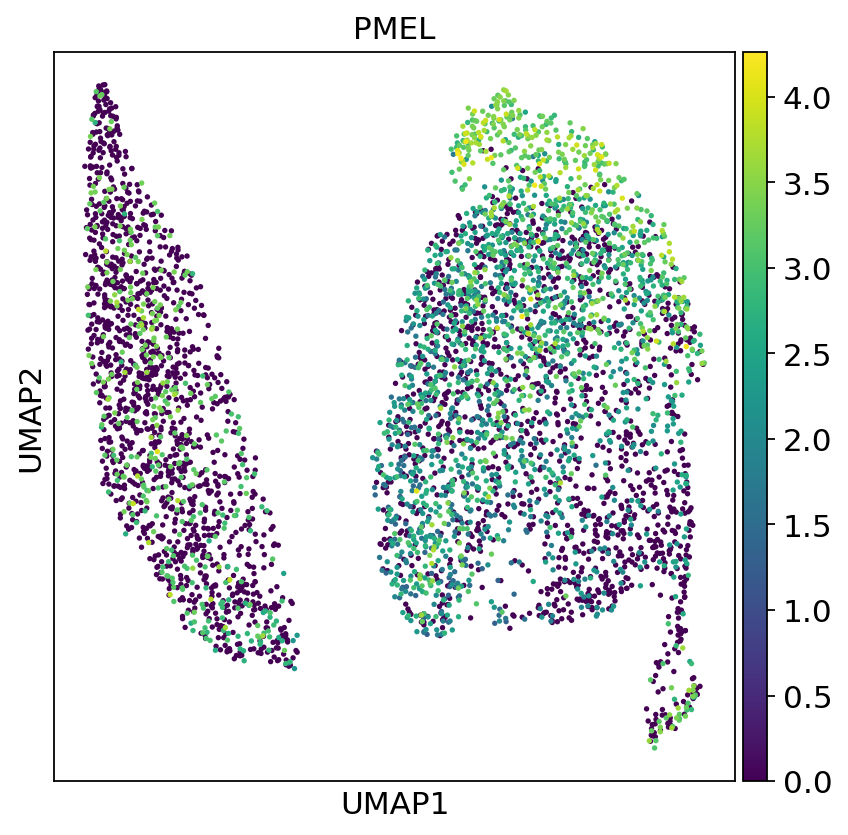

In [155]:
sc.pl.umap(adata,color="SOX10",legend_loc="on data")
sc.pl.umap(adata,color="PMEL",legend_loc="on data")

In [131]:
adata.layers["scaled"]=sc.pp.scale(adata.X,copy=True)

In [160]:
sc.tl.rank_genes_groups(adata,groupby="leiden",method="wilcoxon")

In [157]:
sc.tl.dendrogram(adata,"leiden")

/home/lfaure/miniconda3/envs/gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


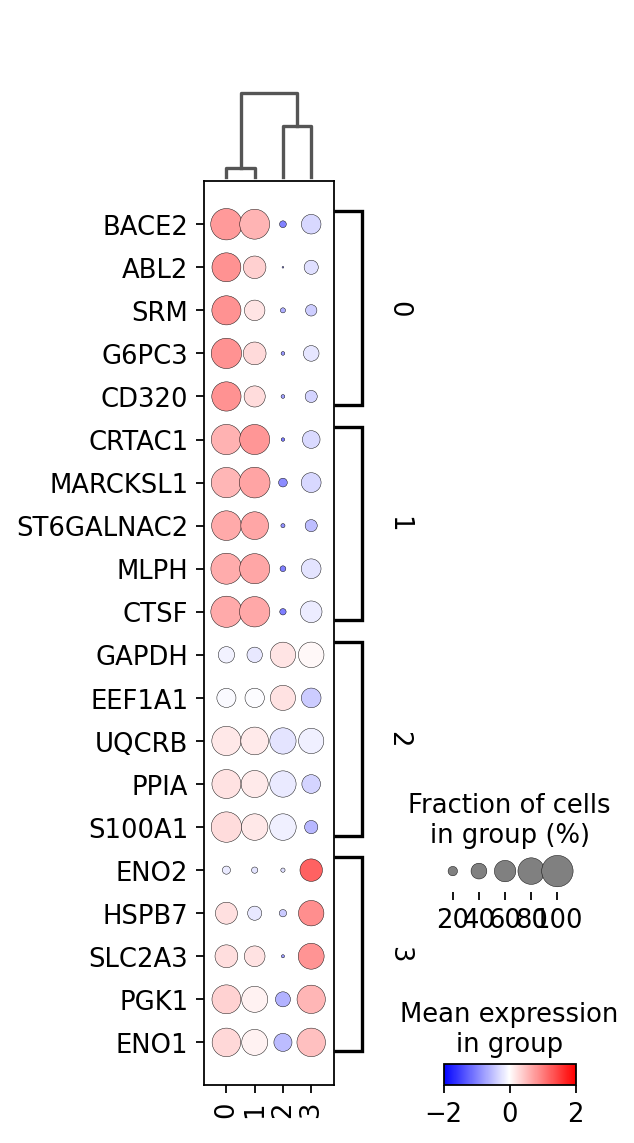

In [162]:
sc.pl.rank_genes_groups_dotplot(adata,cmap="bwr",layer="scaled",n_genes=5,vmin=-2,vmax=2,swap_axes=True)

In [17]:
import palantir

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [18]:
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names),knn=100)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [19]:
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)

In [20]:
tsne = palantir.utils.run_tsne(ms_data,n_jobs=-1,perplexity=200)

In [21]:
adata.obsm["X_palantir"]=ms_data.values

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


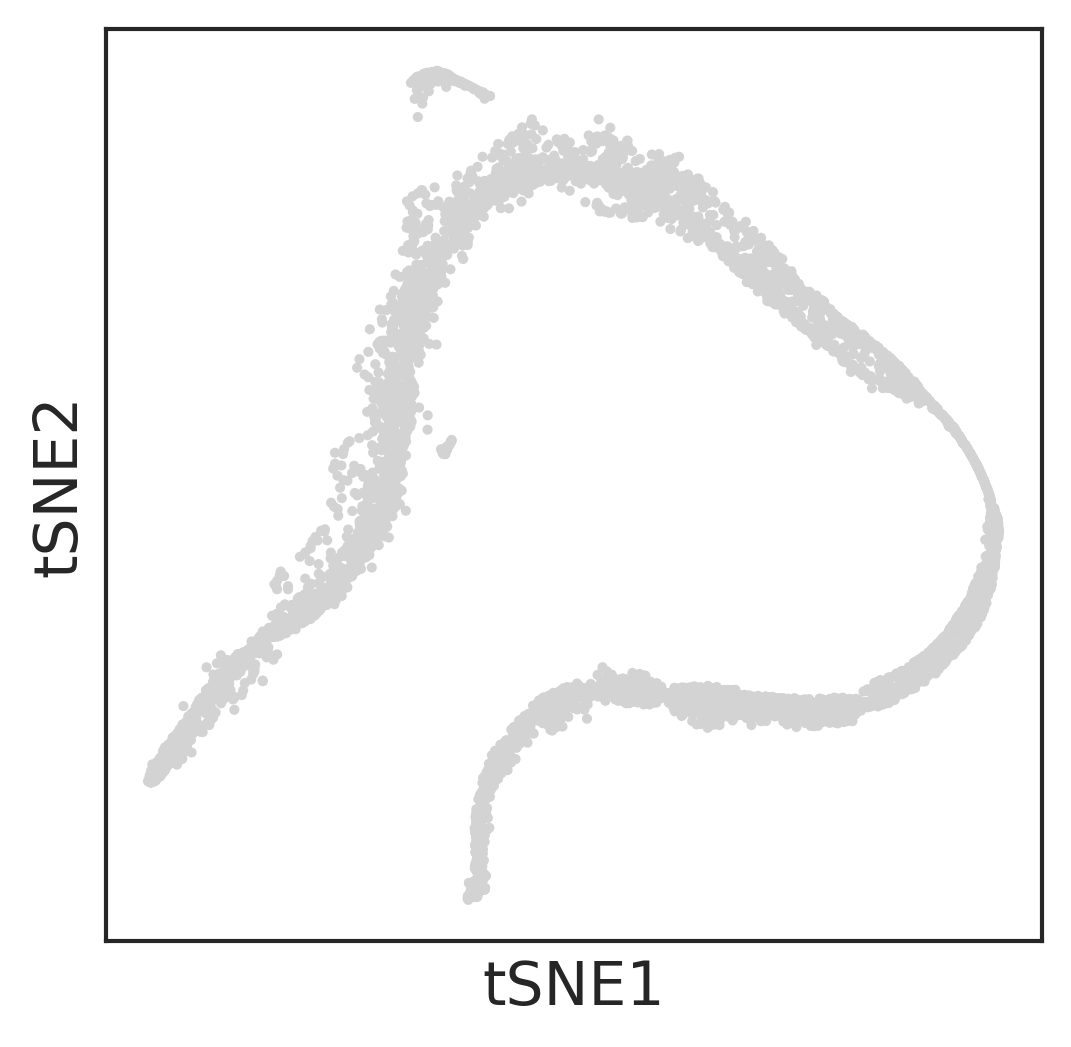

In [22]:
adata.obsm["X_tsne"]=tsne.values
sc.pl.tsne(adata)

In [23]:
adata_raw=sc.read("adata_raw.h5ad")

In [24]:
adata_raw=adata_raw[adata.obs_names]

In [25]:
sc.pp.filter_genes(adata_raw,min_cells=1)

filtered out 6270 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


In [7]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [27]:
%%R -i adata_raw -o ct
source("CytoTRACE.R")
rownames(adata_raw@assays@data$X)=rownames(adata_raw)
colnames(adata_raw@assays@data$X)=colnames(adata_raw)
results=CytoTRACE(adata_raw@assays@data$X,ncores=1)
ct=results$CytoTRACE

R[write to console]: The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

R[write to console]: CytoTRACE will be run on 5 sub-sample(s) of approximately 1019 cells each using 1 / 1 core(s)

R[write to console]: Pre-processing data and generating similarity matrix...

R[write to console]: Calculating gene counts signature...

R[write to console]: Smoothing values with NNLS regression and diffusion...

R[write to console]: Calculating genes associated with CytoTRACE...

R[write to console]: Done



In [28]:
adata.obs["CytoTRACE"]=ct

In [227]:
sc.set_figure_params(dpi_save=600)

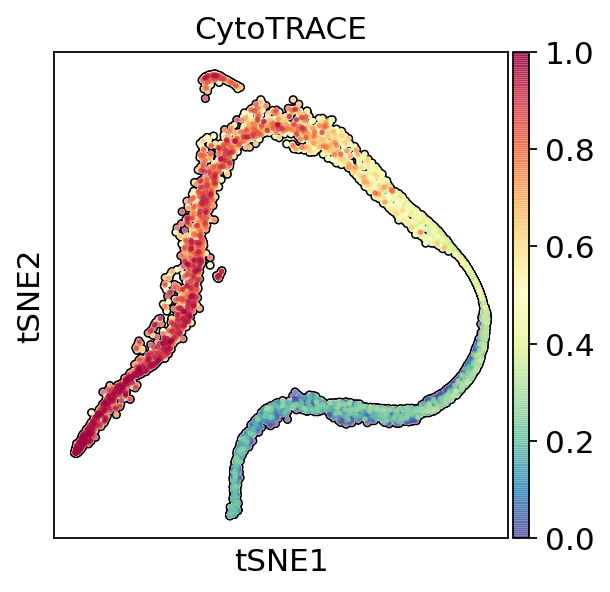

In [229]:
sc.pl.tsne(adata,color="CytoTRACE",color_map="Spectral_r",add_outline=True,
          save="Melanoma_CytoTRACE.png")

In [30]:
adata.write_h5ad("adata_2_pal.h5ad")

In [1]:
import scipy.io
import numpy as np
import scanpy as sc
adata=sc.read("adata_2_pal.h5ad")
adata_raw=sc.read("adata_raw.h5ad")

scipy.io.mmwrite("traj_2_matrix.mtx",adata_raw[adata.obs_names].X.astype(int))
barcodes=adata.obs_names.tolist()
features=adata_raw.var_names.tolist()

/home/lfaure/miniconda3/envs/gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [2]:
adata_ss2 = sc.read('../../SS2/adata_tree_analyzed.h5ad')

In [3]:
adata_ss2.obs.milestones.to_csv("milestones.csv",header=False)

In [4]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [5]:
%%R -i barcodes -i features -o graph_conn -o members -o milestones_proj -o proj_names
library(conos)
library(Matrix)

load("../../SS2/p2_Sox10_mega.RData")
p2$calculatePcaReduction(nPcs=100,maxit=1000)

mls = read.csv("milestones.csv",header=FALSE,row.names=1)
milestones = mls$V2
names(milestones)=rownames(mls)

mtx=as(readMM("traj_2_matrix.mtx"), "dgCMatrix")
rownames(mtx)=barcodes
colnames(mtx)=stringr::str_to_title(features)
p2_mel=pagoda2::basicP2proc(t(mtx),n.cores = 20,n.odgenes = NULL,get.largevis=FALSE,get.tsne = FALSE, make.geneknn=FALSE)

panel<-list(p2,p2_mel)
names(panel)<-c("ss2","melanoma")

con <- Conos$new(panel, n.cores=1)
con$buildGraph(k=15, k.self=5, space='PCA', ncomps=30)

graph_conn <- igraph::as_adjacency_matrix(con$graph, attr="weight")
members = colnames(graph_conn)

cellannot = p2$clusters$PCA$leiden
leiden_proj <- con$propagateLabels(labels = cellannot, verbose=FALSE)
milestones_proj <- con$propagateLabels(labels = milestones, verbose=FALSE)
proj_names <- names(leiden_proj$labels)

R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




running PCA using 5994 OD genes .... done


R[write to console]: 5096cells,27892genes; normalizing ... 

R[write to console]: using plain model 

R[write to console]: winsorizing ... 

R[write to console]: log scale ... 

R[write to console]: done.


R[write to console]: calculating variance fit ...

R[write to console]:  using gam 

R[write to console]: 2630overdispersed genes ...2630

R[write to console]: persisting ... 

R[write to console]: done.


R[write to console]: running PCA using 2630 OD genes .

R[write to console]: .

R[write to console]: .

R[write to console]: .

R[write to console]:  done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


R[write to console]: found 0 out of 1 cached PCA space pairs ... 

R[write to console]: running 1 additional PCA space pairs 



.

R[write to console]:  done

R[write to console]: inter-sample links using mNN 



.

R[write to console]:  done

R[write to console]: local pairs 

R[write to console]: .

R[write to console]: .

R[write to console]:  done


R[write to console]: building graph .



.

R[write to console]: done



In [6]:
import pandas as pd
members=pd.Series(members)

In [7]:
ss2_members=members[members.str.contains("SS2")]
tenx_members=members[~members.str.contains("SS2")]
graph_conn=graph_conn[tenx_members.index,:][:,ss2_members.index]
ss2_members.reset_index(drop=True,inplace=True)
tenx_members.reset_index(drop=True,inplace=True)


In [83]:
milestones_proj=pd.Series(milestones_proj.rx("labels")[0],index=proj_names)

AttributeError: 'Series' object has no attribute 'rx'

In [187]:

adata_sub=adata.copy()[tenx_members]
pseudotime=adata_ss2[ss2_members].obs.t.values
adata_sub.obs["pseudotime_proj"]=list(map(lambda i: np.nansum((graph_conn[i,:].A*pseudotime)[0]/np.sum(graph_conn[i,:].A[0])),range(graph_conn.shape[0])))

Trying to set attribute `.obs` of view, copying.


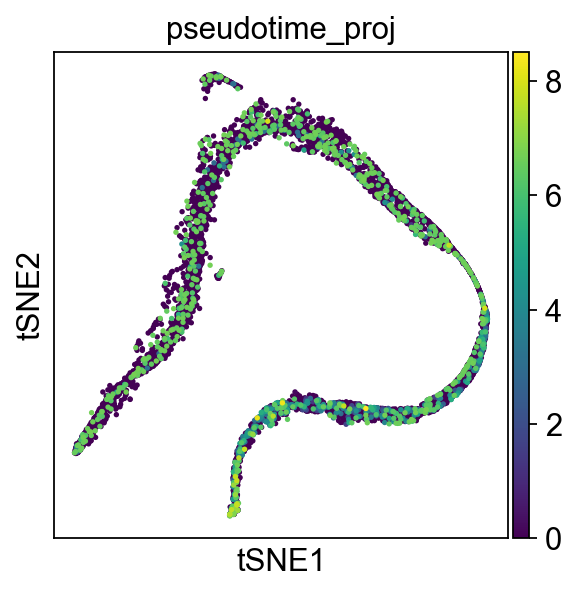

In [188]:
sc.set_figure_params(dpi_save=600)
sc.pl.tsne(adata_sub,color="pseudotime_proj",cmap='viridis')

In [189]:
from scipy.stats import pearsonr
p_corr=pearsonr(adata_sub.obs["CytoTRACE"],adata_sub.obs["pseudotime_proj"])

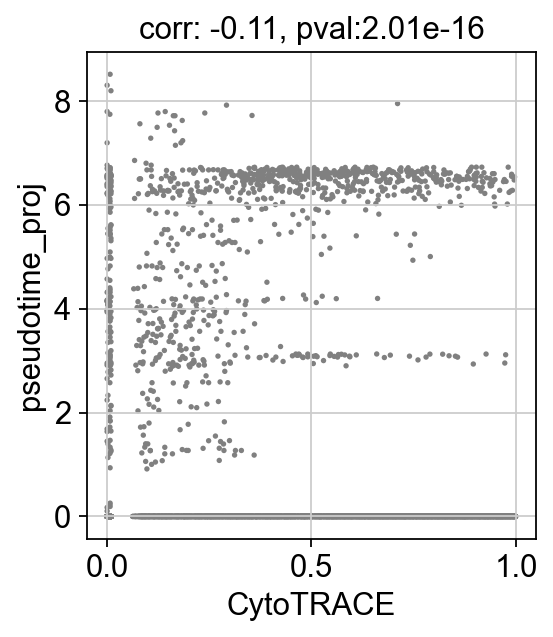

In [190]:
sc.pl.scatter(adata_sub,x="CytoTRACE",y="pseudotime_proj",show=False,
              title="corr: "+"{:.2f}".format(p_corr[0])+", pval:"+"{:.2e}".format(p_corr[1]))

In [191]:
adata_sub.obs["milestones_proj"]=milestones_proj.loc[adata_sub.obs_names].values

In [192]:
adata_sub.obs["milestones_proj"]=adata_sub.obs["milestones_proj"].astype('category')

In [193]:
adata_sub.obs.milestones_proj=adata_sub.obs.milestones_proj.cat.reorder_categories(adata_ss2.obs.milestones.cat.categories)

In [194]:
adata_sub.uns["milestones_proj_colors"]=adata_ss2.uns["milestones_colors"]

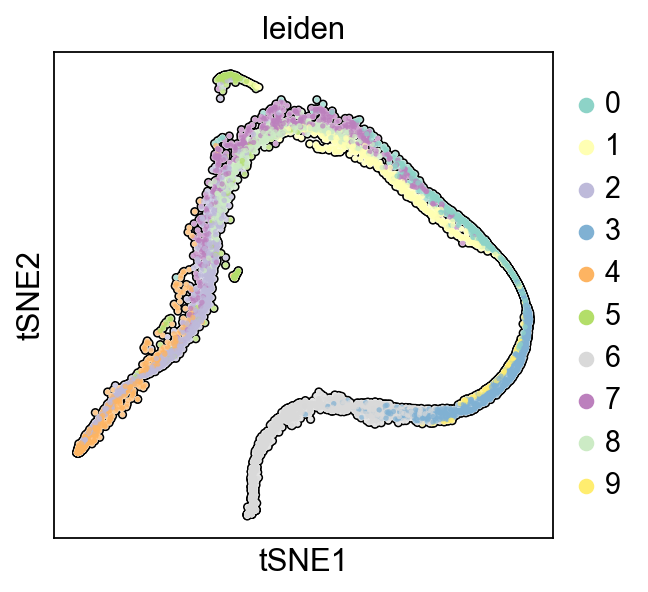

In [195]:

sc.pl.tsne(adata_sub,color="leiden",palette='Set3',add_outline=True,save="_Melanoma_leiden.png")

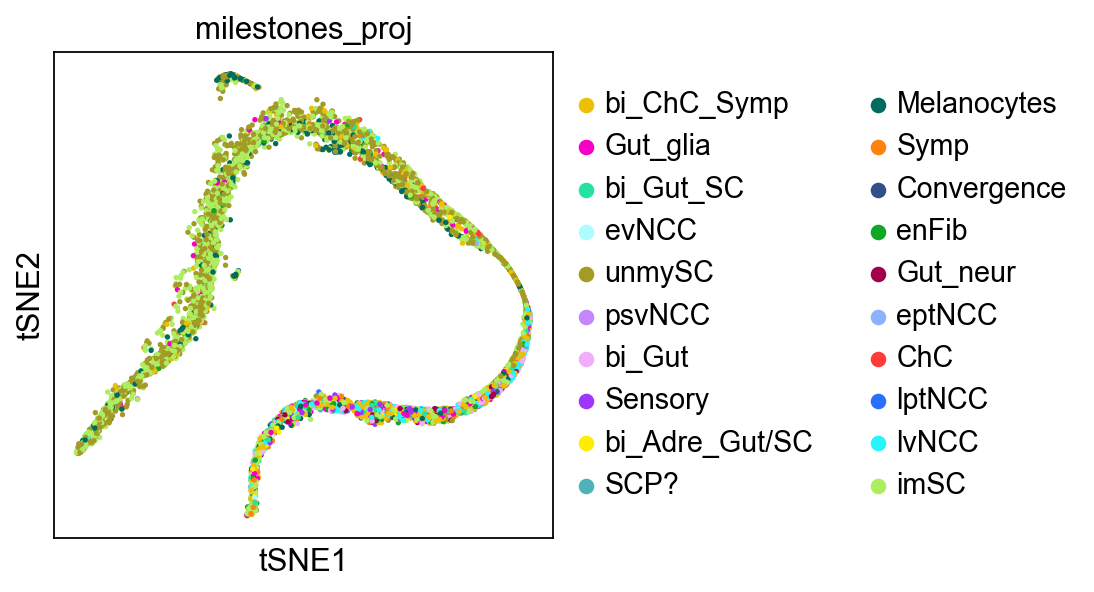

In [196]:
sc.pl.tsne(adata_sub,color="milestones_proj",save="_Melanoma_leiden_proj.png")

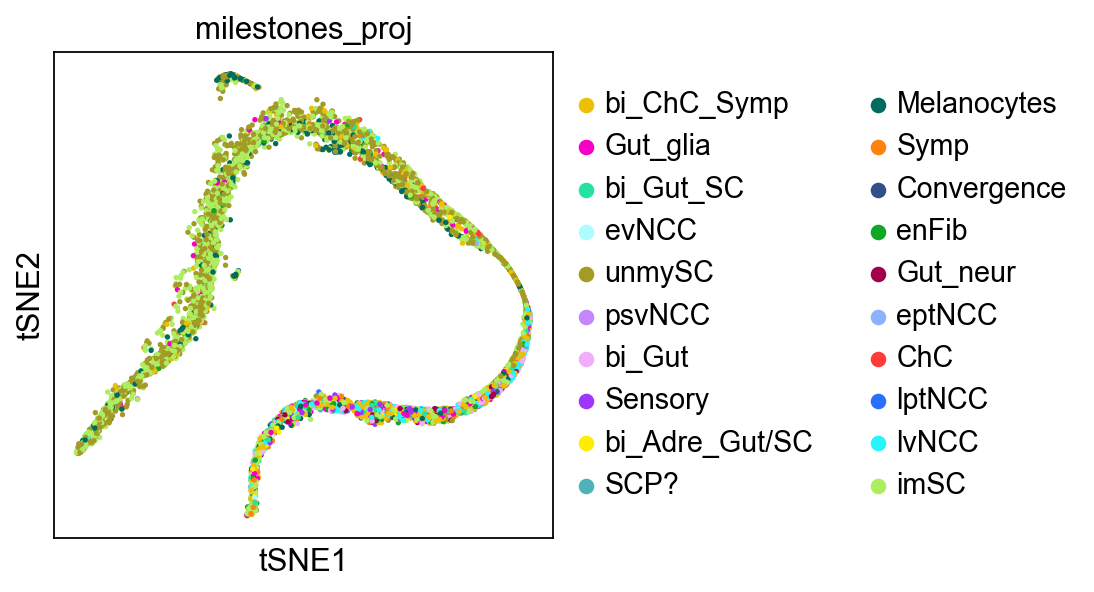

In [197]:
sc.pl.tsne(adata_sub,color="milestones_proj",save="_Melanoma_leiden_proj.png")

In [198]:
umap=np.asarray(adata_ss2[ss2_members].obsm["X_umap"])
proj_umap=list(map(lambda i: [np.nansum((graph_conn[i,:].A*umap[:,0])[0]/np.sum(graph_conn[i,:].A[0])),
                              np.nansum((graph_conn[i,:].A*umap[:,1])[0]/np.sum(graph_conn[i,:].A[0]))],
                   range(graph_conn.shape[0])))

adata_sub.obsm["X_umap"]=pd.DataFrame(proj_umap,index=tenx_members).loc[adata_sub.obs_names].values

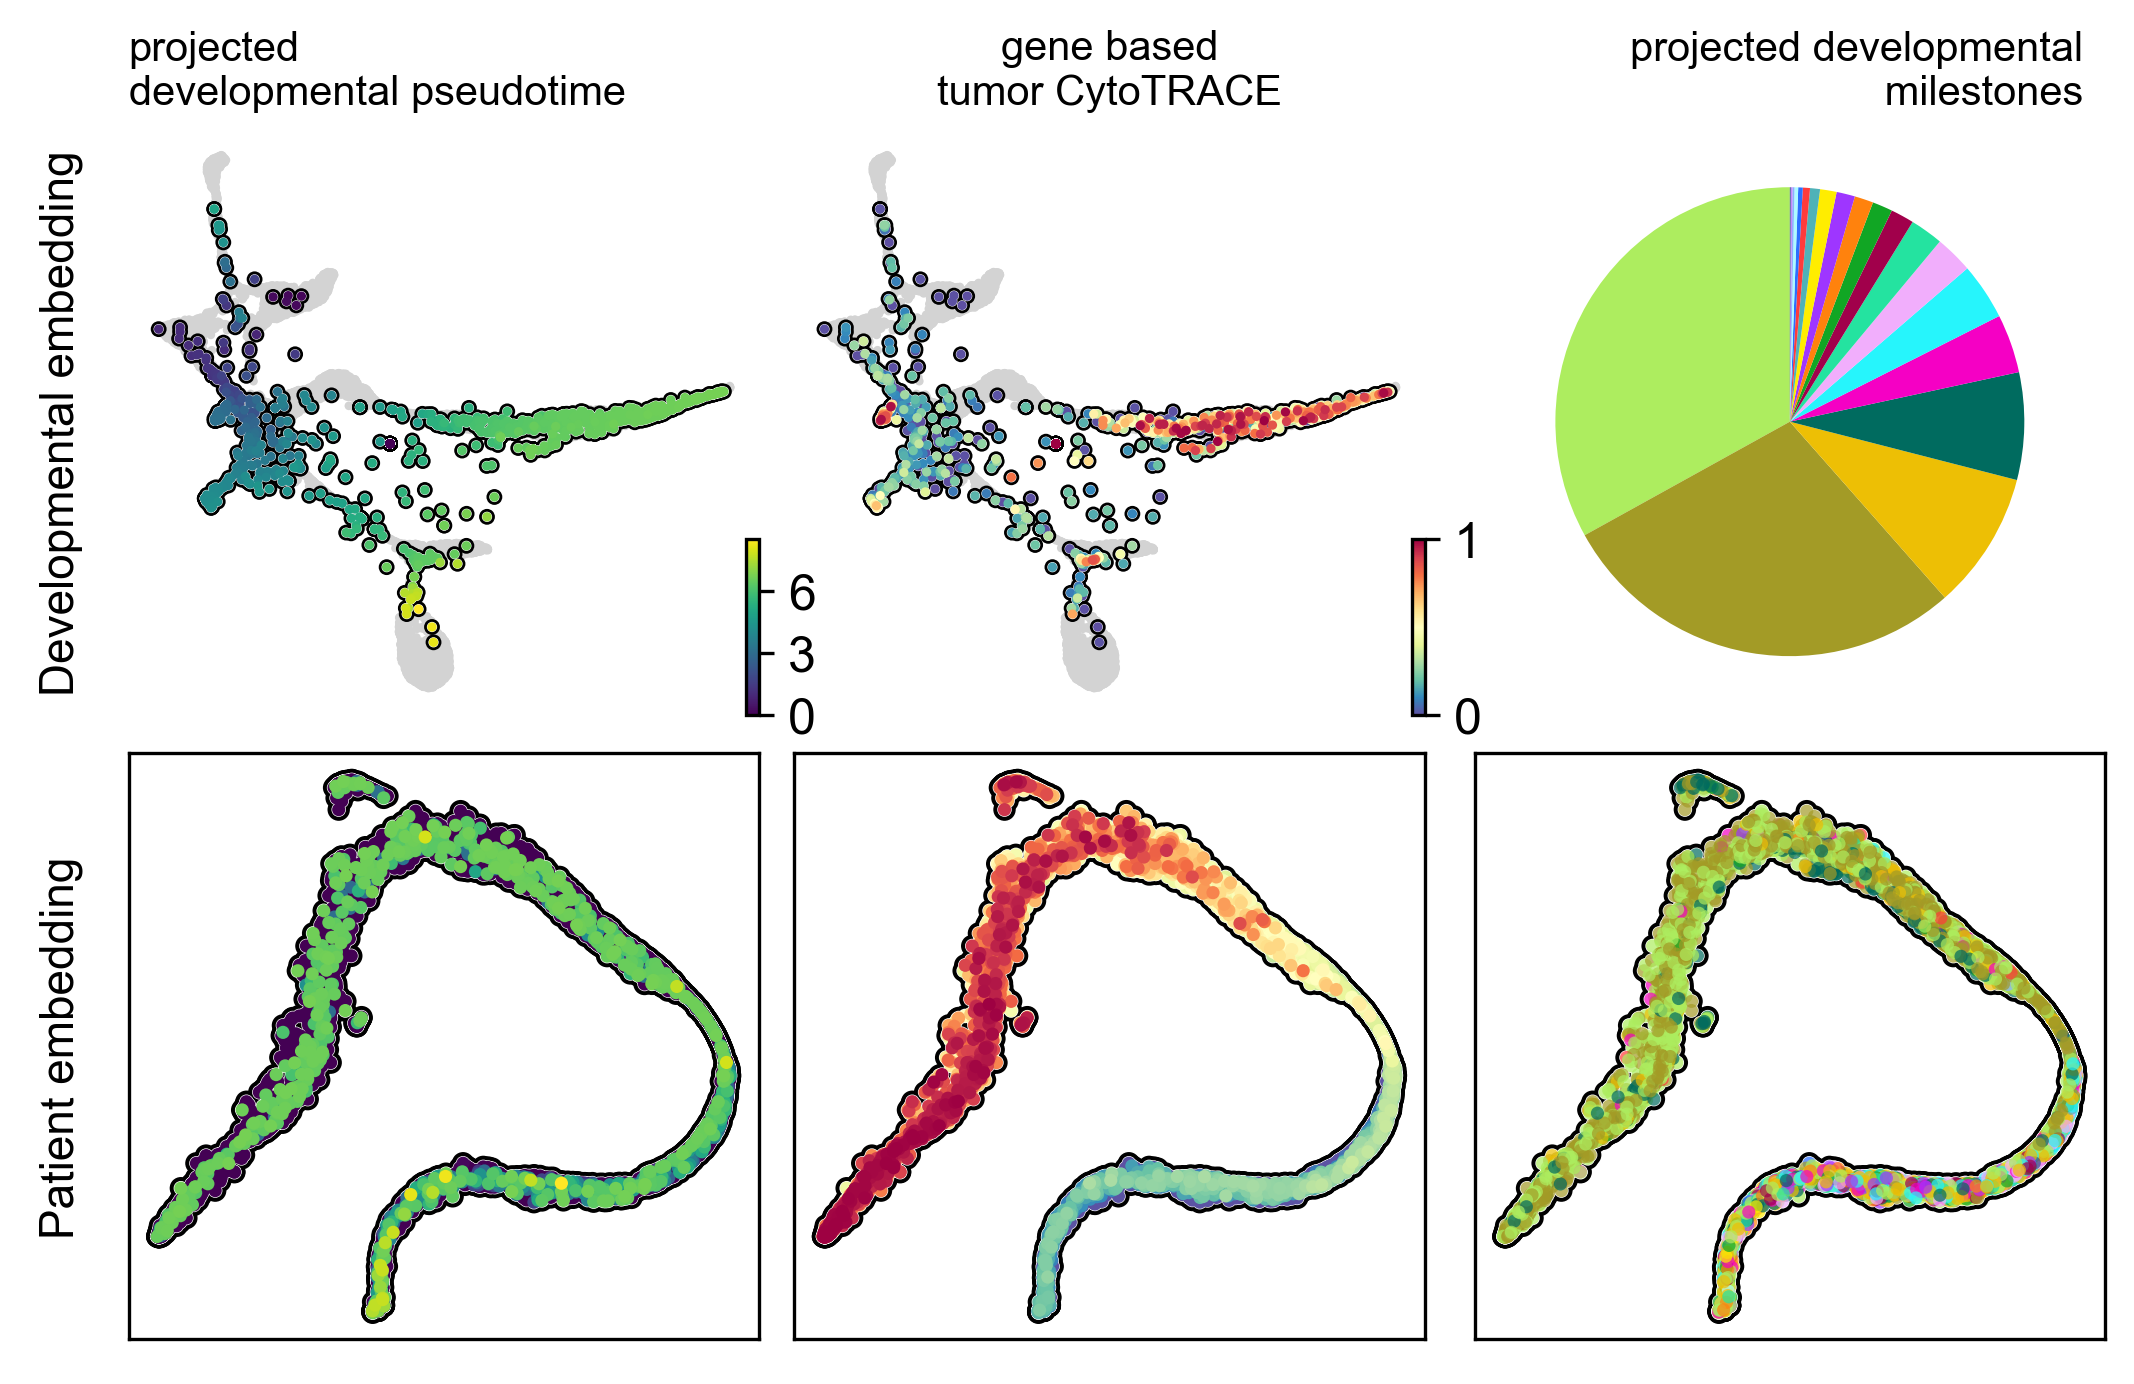

In [218]:
import scvelo as scv
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']


fig = plt.figure(constrained_layout=True,figsize=(7,4.5))
widths = [2, 3, 1.5]
heights = [1, 3, 2]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=[1,10,10,10])

scv.set_figure_params(figsize=(5,5),dpi=150,frameon=False,fontsize=12,dpi_save=600)

ax = fig.add_subplot(spec[0, 1])

sc.pl.umap(adata_ss2,ax=ax,show=False,legend_loc=False,title='')
scv.pl.scatter(adata_sub, c="pseudotime_proj",ax=ax, cmap='viridis',title='',
               show=False,zorder=99,size=20,add_outline=True)

ax.set_title("projected\ndevelopmental pseudotime",loc='left',fontdict={'fontsize':10})


ax = fig.add_subplot(spec[0, 2])

sc.pl.umap(adata_ss2,ax=ax,show=False,legend_loc=False)
scv.pl.scatter(adata_sub, c="CytoTRACE",ax=ax, cmap='Spectral_r',title="",
               show=False,zorder=99,size=20,add_outline=True)

ax.set_title("gene based\ntumor CytoTRACE",loc='center',fontdict={'fontsize':10})

ax = fig.add_subplot(spec[1, 1])

scv.pl.scatter(adata_sub,basis="tsne", c="pseudotime_proj",ax=ax, cmap='viridis',title="",
               show=False,zorder=99,size=40,colorbar=False,add_outline=True,frameon=True)
ax.set_xlabel("")
ax.set_ylabel("")


ax = fig.add_subplot(spec[1, 2])

scv.pl.scatter(adata_sub,basis="tsne", c="CytoTRACE",ax=ax, cmap='Spectral_r',title="",
               show=False,zorder=99,size=40,colorbar=False,add_outline=True,frameon=True)


ax.set_xlabel("")
ax.set_ylabel("")

props=adata_sub.obs.milestones_proj.value_counts()
props=props[props!=0]
devtimecol=dict(zip(adata_sub.obs.milestones_proj.cat.categories,adata_sub.uns["milestones_proj_colors"]))
labels = props.index.to_list()
sizes = props.to_list()
cols= [devtimecol[l] for l in labels]

ax = fig.add_subplot(spec[0, 3])

ax.pie(sizes,colors=cols,
        shadow=False, startangle=90,radius=1)
ax.axis()
ax.set_title("projected developmental\n milestones",loc='right',fontdict={'fontsize':10})


ax = fig.add_subplot(spec[1, 3])

sc.pl.tsne(adata_sub,color="milestones_proj",ax=ax,add_outline=True,frameon=True,show=False,legend_loc="None",size=40,title="")
ax.set_xlabel("")
ax.set_ylabel("")
#plt.savefig("figures/"+p+".pdf",bbox_inches='tight')


ax = fig.add_subplot(spec[0, 0])

ax.text(0.5, 0.5, 'Developmental embedding',fontsize=11,
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        transform=ax.transAxes)
ax.axis('off')

ax = fig.add_subplot(spec[1, 0])

ax.text(0.5, 0.5, 'Patient embedding',fontsize=11,
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        transform=ax.transAxes)
ax.axis('off')
plt.savefig("figures/overview.svg",bbox_inches='tight')



In [200]:
adata_sub.obs.milestones_proj.cat.categories

Index(['bi_ChC_Symp', 'Gut_glia', 'bi_Gut_SC', 'evNCC', 'unmySC', 'psvNCC',
       'bi_Gut', 'Sensory', 'bi_Adre_Gut/SC', 'SCP?', 'Melanocytes', 'Symp',
       'Convergence', 'enFib', 'Gut_neur', 'eptNCC', 'ChC', 'lptNCC', 'lvNCC',
       'imSC'],
      dtype='object')

In [201]:
import seaborn as sns

In [202]:
def traverse(a):
    if not isinstance(a, list):
        yield a
    else:
        for e in a:
            yield from traverse(e)

In [203]:
sel=['imSC','unmySC','bi_ChC_Symp','Melanocytes']



In [209]:
sub_obs=adata_sub[adata_sub.obs.milestones_proj.isin(sel)].obs

In [210]:
sub_obs.milestones_proj.cat.reorder_categories(['Melanocytes','bi_ChC_Symp', 'unmySC', 'imSC'],inplace=True)


In [211]:
sub_obs.milestones_proj.cat.categories

Index(['Melanocytes', 'bi_ChC_Symp', 'unmySC', 'imSC'], dtype='object')

In [212]:
pal=[adata_sub.uns['milestones_proj_colors'][list(traverse(np.argwhere(adata_sub.obs.milestones_proj.cat.categories==s).tolist()))[0]] for s in sub_obs.milestones_proj.cat.categories]

In [232]:
adata_sub.layers["scaled"]=sc.pp.scale(adata_sub.X,copy=True)
adata_sub=adata_sub[:,~adata_sub.var_names.str.contains("^RPL*")]
adata_sub=adata_sub[:,~adata_sub.var_names.str.contains("^RPS*")]
adata_sub=adata_sub[:,~adata_sub.var_names.str.contains("^MT-*")]
sc.tl.rank_genes_groups(adata_sub,"milestones_proj",groups=['Melanocytes','bi_ChC_Symp', 'unmySC', 'imSC'],method='wilcoxon')


Trying to set attribute `.uns` of view, copying.


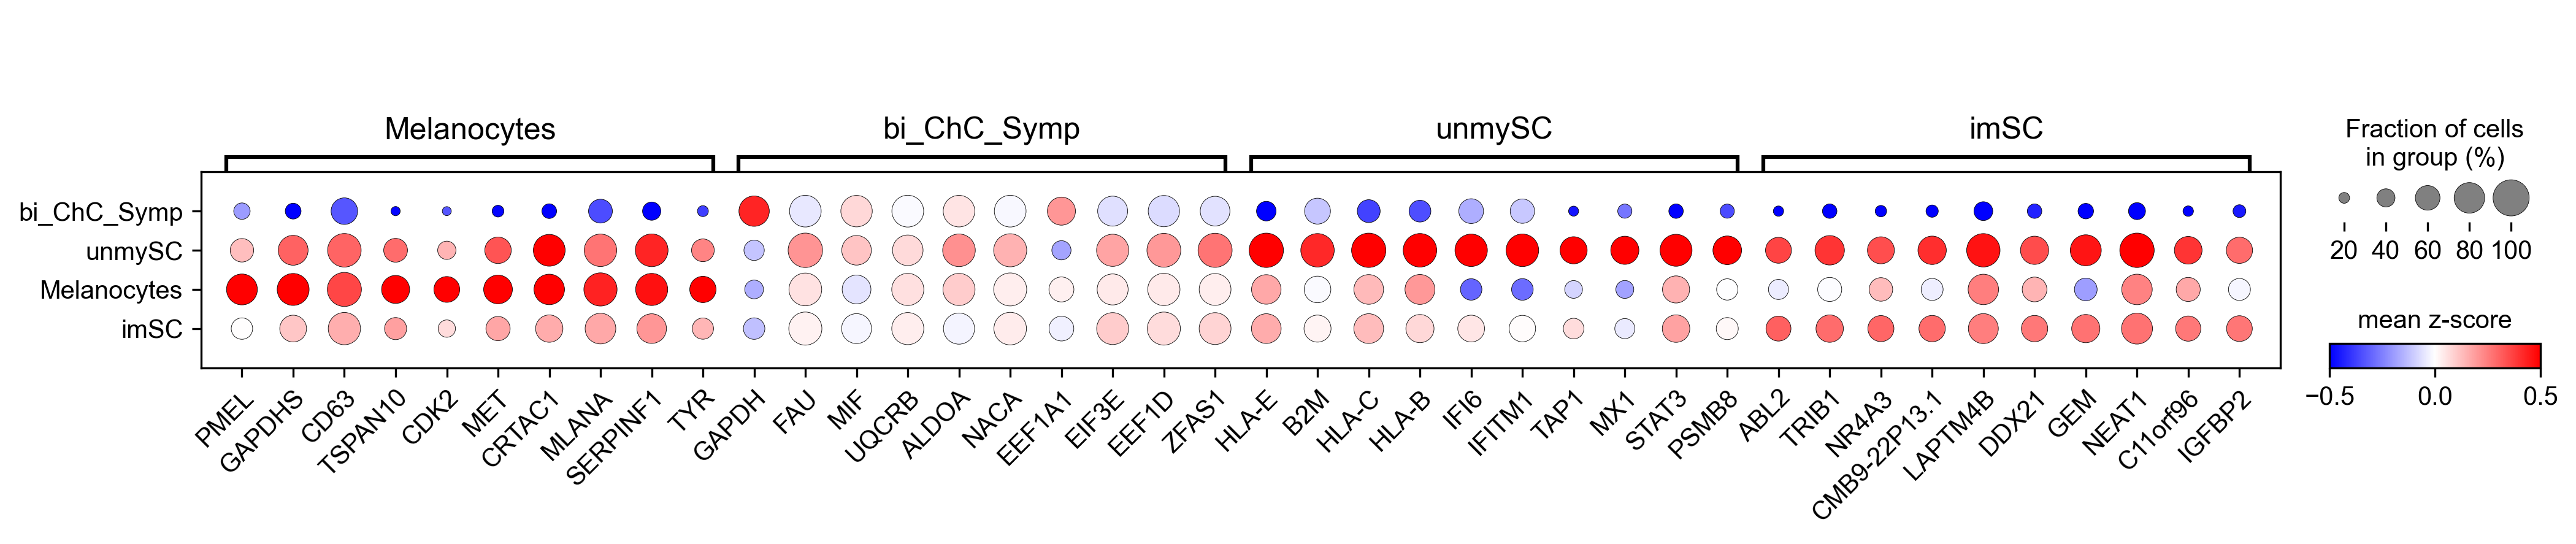

In [236]:
ax=sc.pl.rank_genes_groups_dotplot(adata_sub[adata_sub.obs.milestones_proj.isin(['Melanocytes','bi_ChC_Symp', 'unmySC', 'imSC'])],
                                groups=['Melanocytes','bi_ChC_Symp', 'unmySC', 'imSC'],dendrogram=False,layer='scaled',
                               cmap='bwr',vmin=-0.5,vmax=0.5,show=False,var_group_rotation=0,
                                  colorbar_title='mean z-score')
plt.setp(ax['mainplot_ax'].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.savefig("figures/dotplot.svg",bbox_inches='tight')

In [213]:
sub_obs.milestones_proj

AAACGGGAGTAAGTAC-6           imSC
AAACGGGCAAGTCATC-6           imSC
AAACGGGGTACAGTTC-6         unmySC
AAACGGGTCACAACGT-6           imSC
AAAGATGCACACCGAC-6           imSC
                         ...     
TTTGCGCTCCTTTCTC-6    bi_ChC_Symp
TTTGCGCTCTTGAGAC-6    Melanocytes
TTTGGTTGTTTGTTTC-6         unmySC
TTTGTCAAGTGAACAT-6    Melanocytes
TTTGTCACACCGGAAA-6    Melanocytes
Name: milestones_proj, Length: 3995, dtype: category
Categories (4, object): ['Melanocytes', 'bi_ChC_Symp', 'unmySC', 'imSC']

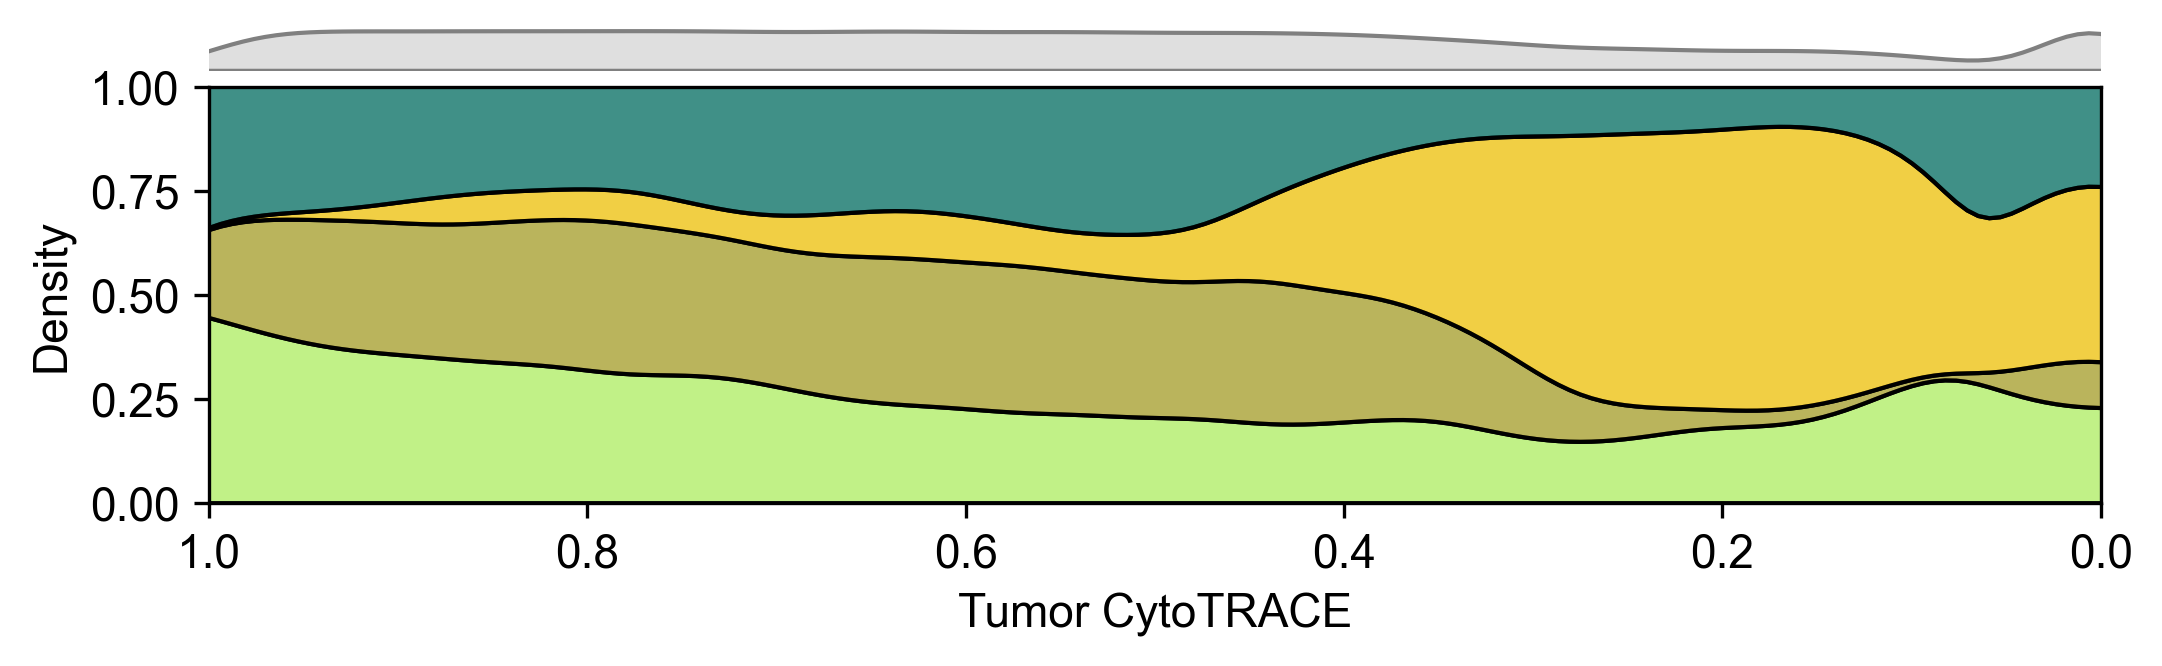

In [238]:
fig, (ax1,ax2) = plt.subplots(figsize=(7,2),nrows=2,gridspec_kw={'height_ratios':[1,10]})



sns.kdeplot(data=sub_obs,
            x="CytoTRACE",ax=ax1,bw_adjust=0.5,fill=True,color='grey')

ax1.set_xlim(adata_sub.obs.CytoTRACE.max(),0)
ax1.axis('off')
sns.kdeplot(data=sub_obs,common_norm=False,
            x="CytoTRACE", hue="milestones_proj",fill=True,bw_adjust=0.5, multiple="fill",
           palette=sns.color_palette(pal),legend=False,ax=ax2)
ax2.set_xlim(adata_sub.obs.CytoTRACE.max(),0)

ax2.set_xlabel('Tumor CytoTRACE')

plt.tight_layout(pad=0,h_pad=0,w_pad=0)
plt.savefig("figures/CytoTRACE_vs_mainmils.svg",bbox_inches='tight')